Creation of a fine tunned version of Bert.
The first block of code iterates through different combinations of learning rate and batch size to find the optimal setup. 

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import optuna
from sklearn.metrics import classification_report, precision_score

# Prepare the tokenizer for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define a custom dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings.input_ids)

# Load the dataset
deberta_df = pd.read_csv('filtered_data.csv')
texts = deberta_df['reviews.text'].astype(str).fillna('').tolist()
deberta_df['sentiment'] = deberta_df['reviews.rating'].map(lambda x: 'negative' if x in [1, 2] else ('neutral' if x == 3 else 'positive'))
labels = deberta_df['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2}).tolist()

# Split the data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.1, stratify=labels)
train_dataset = SentimentDataset(train_texts, train_labels)
val_dataset = SentimentDataset(val_texts, val_labels)

# Ensure GPU usage
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Compute class weights to handle class imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Load BERT model with classification head
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3).to(device)

# Objective Function for Hyperparameter Tuning
def objective(trial):
    # Define hyperparameters to tune
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])

    # Set training arguments
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=3,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_steps=100,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_dir='./logs',
        logging_steps=10,
        report_to="none",
        learning_rate=learning_rate
    )

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2024-10-15 09:25:59,564] A new study created in memory with name: no-name-4bbe7f21-e571-4fae-bb7c-2eef631dd582
<ipython-input-4-5d7e156511af>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.185100,0.691796
2,0.868900,0.652615
3,0.095700,0.736608


[I 2024-10-15 10:03:10,956] Trial 0 finished with value: 0.736607551574707 and parameters: {'learning_rate': 2.499883248337129e-05, 'batch_size': 8}. Best is trial 0 with value: 0.736607551574707.
<ipython-input-4-5d7e156511af>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.086000,0.897126
2,0.411500,0.807973
3,0.024300,0.838050


[I 2024-10-15 10:39:53,048] Trial 1 finished with value: 0.8380496501922607 and parameters: {'learning_rate': 3.8818978087838796e-05, 'batch_size': 8}. Best is trial 0 with value: 0.736607551574707.
<ipython-input-4-5d7e156511af>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.000300,0.931019
2,0.289800,0.786981
3,0.000500,0.927093


[I 2024-10-15 11:16:39,550] Trial 2 finished with value: 0.9270930886268616 and parameters: {'learning_rate': 4.076076205686867e-05, 'batch_size': 8}. Best is trial 0 with value: 0.736607551574707.
<ipython-input-4-5d7e156511af>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.100400,1.089058
2,0.000100,1.092251
3,0.000400,1.206355


[I 2024-10-15 11:49:20,212] Trial 3 finished with value: 1.2063547372817993 and parameters: {'learning_rate': 1.4051107733031436e-05, 'batch_size': 16}. Best is trial 0 with value: 0.736607551574707.
<ipython-input-4-5d7e156511af>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.000200,1.283149
2,0.000300,1.104324
3,0.000500,1.146222


[I 2024-10-15 12:22:03,167] Trial 4 finished with value: 1.1462218761444092 and parameters: {'learning_rate': 3.463212942513863e-05, 'batch_size': 16}. Best is trial 0 with value: 0.736607551574707.
<ipython-input-4-5d7e156511af>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.483900,1.253259
2,0.000400,1.174316
3,0.000400,1.315877


[I 2024-10-15 12:54:49,527] Trial 5 finished with value: 1.3158767223358154 and parameters: {'learning_rate': 3.2734521089259716e-05, 'batch_size': 16}. Best is trial 0 with value: 0.736607551574707.
<ipython-input-4-5d7e156511af>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.000100,1.297799
2,0.520700,1.048946
3,0.000300,1.128104


[I 2024-10-15 13:31:56,657] Trial 6 finished with value: 1.1281039714813232 and parameters: {'learning_rate': 1.2996127792021216e-05, 'batch_size': 8}. Best is trial 0 with value: 0.736607551574707.
<ipython-input-4-5d7e156511af>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.001200,1.466028
2,0.019900,1.545278
3,0.000700,1.463925


[I 2024-10-15 14:02:19,417] Trial 7 finished with value: 1.4639252424240112 and parameters: {'learning_rate': 1.2101953911159767e-05, 'batch_size': 32}. Best is trial 0 with value: 0.736607551574707.
<ipython-input-4-5d7e156511af>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.000100,1.195901
2,0.198700,1.043761
3,0.000500,1.141171


[I 2024-10-15 14:40:30,565] Trial 8 finished with value: 1.1411709785461426 and parameters: {'learning_rate': 2.4557578242704975e-05, 'batch_size': 8}. Best is trial 0 with value: 0.736607551574707.
<ipython-input-4-5d7e156511af>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.000500,1.594408
2,0.037700,1.529620
3,0.000700,1.547791


[I 2024-10-15 15:10:24,419] Trial 9 finished with value: 1.5477913618087769 and parameters: {'learning_rate': 1.380070590946973e-05, 'batch_size': 32}. Best is trial 0 with value: 0.736607551574707.


Best parameters found by Optuna: {'learning_rate': 2.499883248337129e-05, 'batch_size': 8}


NameError: name 'WeightedLossTrainer' is not defined

This next block takes in the best parameters found in the iterative block prior and trains the model

In [ ]:
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss
# Use best parameters to reinitialize training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=best_params['batch_size'],
    per_device_eval_batch_size=best_params['batch_size'],
    warmup_steps=100,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    report_to="none",
    learning_rate=best_params['learning_rate']
)

# After training, evaluate based on negative sentiment precision
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Train the model using the best parameters found
trainer.train()
preds_output = trainer.predict(val_dataset)
preds = np.argmax(preds_output.predictions, axis=1)

# Evaluate model based on precision of predicting negative sentiment
report = classification_report(val_labels, preds, target_names=['negative', 'neutral', 'positive'])
negative_precision = precision_score(val_labels, preds, average=None)[0]  # 0 corresponds to 'negative'
print("Classification Report:\n", report)
print("Negative Precision:", negative_precision)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.000200,1.186153
2,0.207800,1.023660
3,0.000300,1.041046


Classification Report:
               precision    recall  f1-score   support

    negative       0.89      0.84      0.86       166
     neutral       0.80      0.63      0.70       134
    positive       0.98      1.00      0.99      2898

    accuracy                           0.97      3198
   macro avg       0.89      0.82      0.85      3198
weighted avg       0.97      0.97      0.97      3198

Negative Precision: 0.8910256410256411


In [ ]:
# Save the model in the same directory
model.save_pretrained('./bert_pretrained')
tokenizer.save_pretrained('./bert_pretrained')



('./bert_pretrained/tokenizer_config.json',
 './bert_pretrained/special_tokens_map.json',
 './bert_pretrained/vocab.txt',
 './bert_pretrained/added_tokens.json')

Should you already have the fine tuned model saved, you can start from here to create predictions on your data set. The first blockl of code is intended as evaluation.

Accuracy: 0.9718574108818011
Weighted Precision: 0.9699189358727272
Weighted Recall: 0.9718574108818011
Weighted F1 Score: 0.9703647474846679

Classification Report:
               precision    recall  f1-score   support

    negative       0.89      0.84      0.86       166
     neutral       0.80      0.63      0.70       134
    positive       0.98      1.00      0.99      2898

    accuracy                           0.97      3198
   macro avg       0.89      0.82      0.85      3198
weighted avg       0.97      0.97      0.97      3198



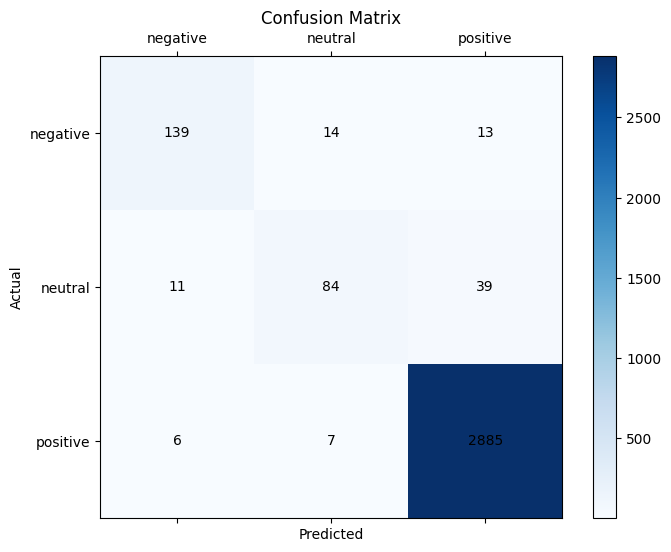


Sample 20 Predictions for Rating 'negative':
Text: now i know why these are so inexpensive im baffled as to how theyve earned such high reviews ive use... | Actual: negative | Predicted: negative
Text: really good price for a reason first two batteries i used were dead do not waste your money... | Actual: negative | Predicted: negative
Text: not worth a crap dont waist your money i purchased these for under cabinet lighting and they hardly ... | Actual: negative | Predicted: negative
Text: not suitable for toys drained within just a couple of days... | Actual: negative | Predicted: negative
Text: i had to return this product as it was not compatible with things such as facebook and itunes which ... | Actual: negative | Predicted: negative
Text: touch response is not so good so my kid refused to play games on thisreturned this product thanks to... | Actual: negative | Predicted: negative
Text: they dont seem to work except in very low energy items cant get them to work in my remotes or

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import pandas as pd

def evaluate_model(trainer, val_dataset, val_labels, val_texts):
    # Get predictions from the validation dataset
    preds_output = trainer.predict(val_dataset)
    # Get the predicted labels by taking the argmax of the prediction logits
    preds = np.argmax(preds_output.predictions, axis=1)

    # Calculate evaluation metrics
    accuracy = accuracy_score(val_labels, preds)  # Overall accuracy of predictions
    precision = precision_score(val_labels, preds, average='weighted')  # Weighted average precision
    recall = recall_score(val_labels, preds, average='weighted')  # Weighted average recall
    f1 = f1_score(val_labels, preds, average='weighted')  # Weighted average F1 score

    # Print evaluation metrics
    print("Accuracy:", accuracy)
    print("Weighted Precision:", precision)
    print("Weighted Recall:", recall)
    print("Weighted F1 Score:", f1)

    # Print classification report for per-class metrics
    target_names = ['negative', 'neutral', 'positive']
    report = classification_report(val_labels, preds, target_names=target_names)
    print("\nClassification Report:\n", report)

    # Confusion Matrix
    cm = confusion_matrix(val_labels, preds)
    plot_confusion_matrix(cm, target_names)  # Plot the confusion matrix

    # Print 20 items per rating from validation dataset
    print_sample_predictions(val_texts, val_labels, preds)  # Print sample predictions for each class

def plot_confusion_matrix(cm, class_names):
    # Create a figure to visualize the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    # Display the confusion matrix with a color map
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    # Add a color bar to provide context to the values
    fig.colorbar(cax)
    # Set the x and y axis labels to the class names
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    # Annotate each cell with the corresponding count
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha='center', va='center', color='black')

    plt.xlabel('Predicted')  # Label x-axis as 'Predicted'
    plt.ylabel('Actual')  # Label y-axis as 'Actual'
    plt.show()  # Show the plot

def print_sample_predictions(val_texts, val_labels, preds, num_samples=20):
    # Create a DataFrame to organize and filter data easily
    data = pd.DataFrame({
        'Text': val_texts,
        'Actual': val_labels,
        'Predicted': preds
    })

    target_names = ['negative', 'neutral', 'positive']
    # Loop through each class (negative, neutral, positive)
    for i, name in enumerate(target_names):
        print(f"\nSample {num_samples} Predictions for Rating '{name}':")
        # Sample up to 'num_samples' rows from the DataFrame where the actual label matches the current class
        samples = data[data['Actual'] == i].sample(n=min(num_samples, len(data[data['Actual'] == i])))
        # Print each sampled text with its actual and predicted labels
        for idx, row in samples.iterrows():
            print(f"Text: {row['Text'][:100]}... | Actual: {target_names[row['Actual']]} | Predicted: {target_names[row['Predicted']]}")

# Evaluate the model
evaluate_model(trainer, val_dataset, val_labels, val_texts)

This block of code creates predictions over the whole dataset and outputs a csv file that includes a new column with the predictions. 

In [ ]:

# Define function to get predictions with BERT model
def predict_sentiment(texts, batch_size=16):
    predictions = []
    model.eval()
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            batch_preds = torch.argmax(logits, axis=1).cpu().numpy()
        predictions.extend(batch_preds)
    return predictions

# Get predictions for the entire dataset
predictions = predict_sentiment(texts)

# Map numeric predictions to sentiment labels
label_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
deberta_df['predicted_sentiment'] = [label_map[pred] for pred in predictions]

# Save the updated DataFrame with predictions to a new CSV file
deberta_df.to_csv('filtered_data_with_predictions.csv', index=False)

print("Predictions have been added to 'filtered_data_with_predictions.csv'.")

Predictions have been added to 'filtered_data_with_predictions.csv'.
